In [19]:
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import io
import matplotlib.pyplot as plt
import seaborn as sns
import simple_icd_10 as icd
import numpy as np

In [18]:
pip install simple_icd_10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 17.0 MB/s eta 0:00:00


In [142]:
df = pd.read_csv(io.BytesIO(uploaded['diagnoses_all.csv']), index_col=0)

In [143]:
df = (df[["icd10_category"]]).drop_duplicates()

In [50]:
tokenizer = AutoTokenizer.from_pretrained("Charangan/MedBERT")
model = AutoModel.from_pretrained("Charangan/MedBERT")

In [144]:
def get_cls(sentence):
    input_ids = tokenizer(sentence)["input_ids"]

    with torch.no_grad():
        outputs = model(torch.tensor(input_ids).unsqueeze(0).cpu())
        cls = outputs.last_hidden_state[:, 0, :].cpu()[0]

    return np.array(cls)

In [145]:
df["cls"] = df["icd10_category"].apply(lambda x: get_cls(x))

In [ ]:
df.head()

,icd10_category,cls
0,K76,"[0.5000243, -0.034329053, -0.24034344, 0.39607..."
1,R18,"[0.9247165, -0.14132555, -0.3087625, 0.7380584..."
2,K74,"[1.4764878, 0.053952347, -0.37734818, -0.06967..."
3,B19,"[0.6161725, -0.49264145, 0.43304953, 1.4612447..."
4,J44,"[1.3610134, -0.5368312, 0.6627724, 1.1268667, ..."


In [9]:
df.to_csv("medbert_embeddings.tsv", sep="\t")

In [34]:
similarity_scores = cosine_similarity(list(df["cls"].values), list(df["cls"].values))

similarity_scores = pd.DataFrame(data=similarity_scores, index=df["icd10_category"].values, columns=df["icd10_category"].values)

similarity_scores = similarity_scores.sort_index().sort_index(axis=1)

In [ ]:
similarity_scores.to_csv("../matrices/mimic_comparison/scores_medbert.csv")

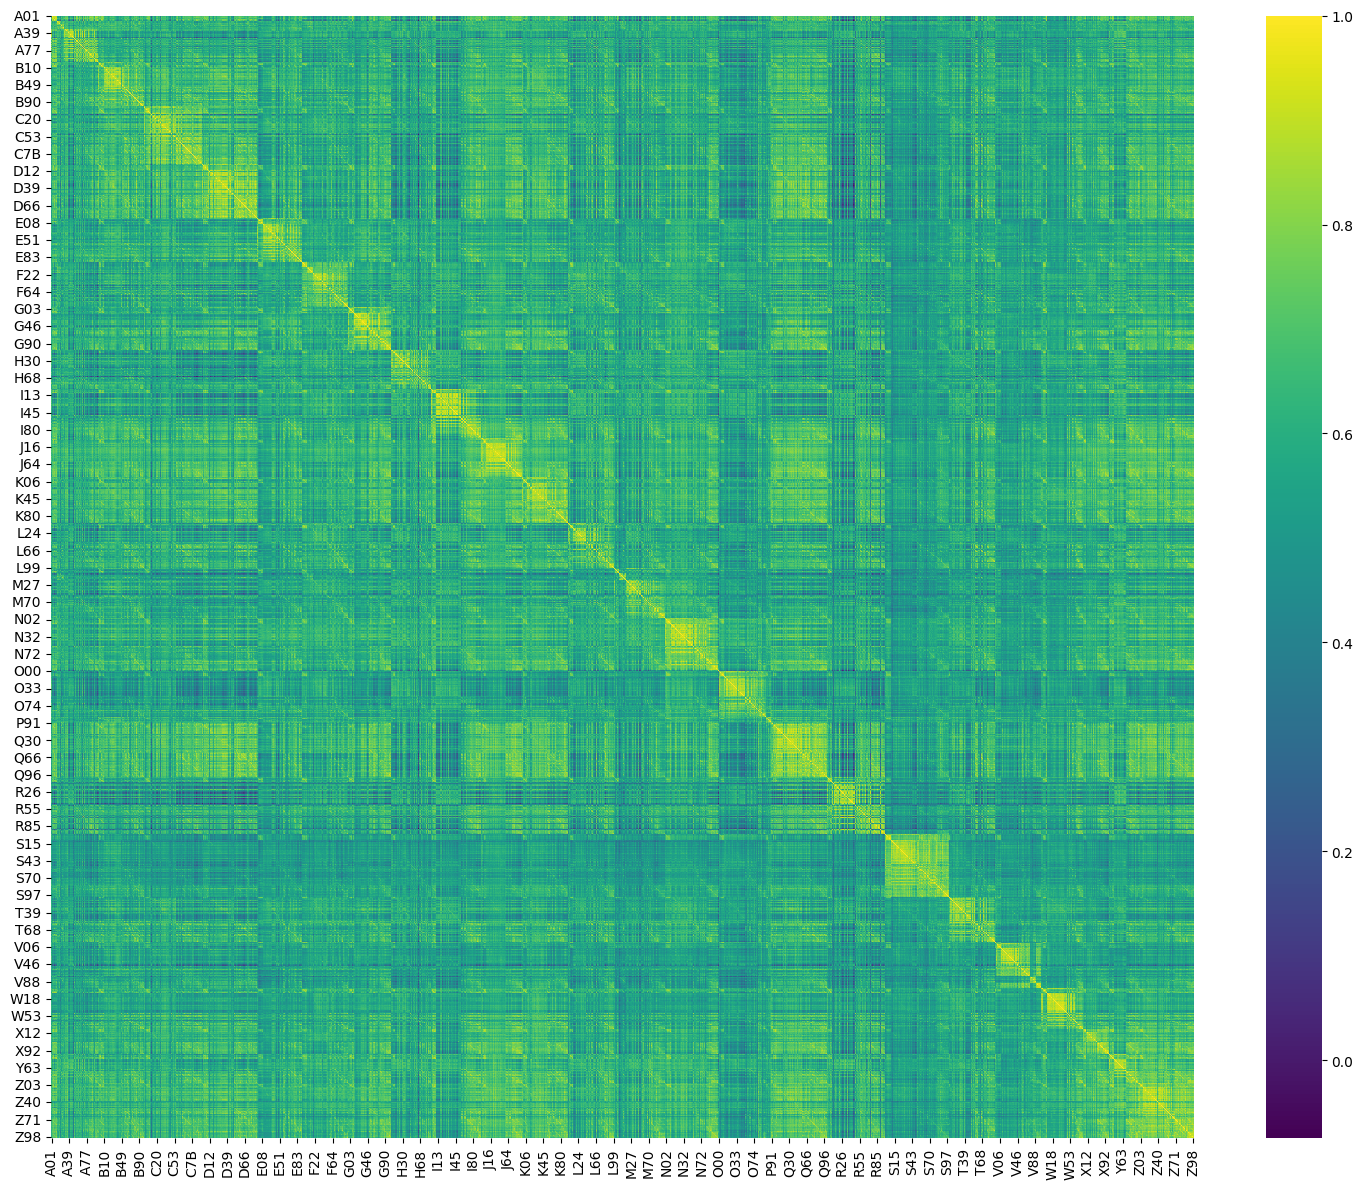

In [11]:
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_scores, cmap ='viridis')
plt.tight_layout()
plt.savefig("medbert.png", dpi=100, bbox_inches='tight')
plt.show()